<a id='top'> </a>
Author: [James Bourbeau](http://www.jamesbourbeau.com)

In [1]:
%load_ext watermark
%watermark -u -d -v -p numpy,matplotlib,scipy,pandas,sklearn,mlxtend

last updated: 2017-04-04 

CPython 2.7.10
IPython 5.3.0

numpy 1.12.0
matplotlib 2.0.0
scipy 0.15.1
pandas 0.19.2
sklearn 0.18.1
mlxtend 0.5.1


# Model parameter-tuning
### Table of contents
2. [Validation curves](#Validation-curves)
3. [KS-test tuning](#KS-test-tuning)

In [2]:
from __future__ import division, print_function
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics import accuracy_score

import composition as comp
import composition.analysis.plotting as plotting

color_dict = comp.analysis.get_color_dict()

%matplotlib inline

/home/jbourbeau/.local/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


# Define analysis free parameters
[ [back to top](#top) ]

In [3]:
comp_class = True
comp_list = ['light', 'heavy'] if comp_class else ['P', 'He', 'O', 'Fe']

In [4]:
pipeline_str = 'GBDT'
pipeline = comp.analysis.get_pipeline(pipeline_str)

In [5]:
scoring = 'accuracy'
cv = 10

## Data preprocessing
1. Load simulation dataframe and apply specified quality cuts
2. Extract desired features from dataframe
3. Get separate testing and training datasets

In [6]:
sim_train, sim_test = comp.preprocess_sim(comp_class=comp_class, return_energy=True)

TypeError: preprocess_sim() got an unexpected keyword argument 'comp_class'

In [7]:
pipeline.fit(sim_train.X, sim_train.y)

Pipeline(steps=[('classifier', GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='exponential', max_depth=5,
              max_features=None, max_leaf_nodes=None,
              min_impurity_split=1e-07, min_samples_leaf=1,
              min_samples_split=2, min_weight_fraction_leaf=0.0,
              n_estimators=100, presort='auto', random_state=2,
              subsample=1.0, verbose=0, warm_start=False))])

In [8]:
# compute test set accuracy
n_estimators = pipeline.named_steps['classifier'].get_params()['n_estimators']
test_score = np.zeros(n_estimators, dtype=np.float64)

for i, y_pred in enumerate(pipeline.named_steps['classifier'].staged_predict(sim_test.X)):
    test_score[i] = accuracy_score(sim_test.y, y_pred)

In [9]:
# compute train set accuracy
n_estimators = pipeline.named_steps['classifier'].get_params()['n_estimators']
train_score = np.zeros(n_estimators, dtype=np.float64)

for i, y_pred in enumerate(pipeline.named_steps['classifier'].staged_predict(sim_train.X)):
    train_score[i] = accuracy_score(sim_train.y, y_pred)

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


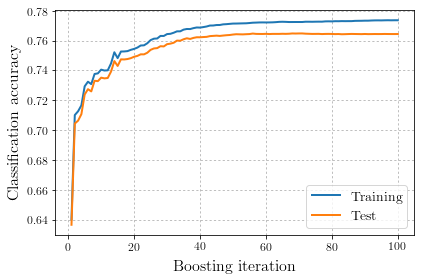

In [10]:
fig, ax = plt.subplots()
ax.plot(range(1, n_estimators+1), train_score, ls='-', lw=2, marker='None', label='Training')
ax.plot(range(1, n_estimators+1), test_score, ls='-', lw=2, marker='None', label='Test')
ax.set_ylabel('Classification accuracy')
ax.set_xlabel('Boosting iteration')
ax.grid()
ax.legend()
plt.savefig('/home/jbourbeau/public_html/figures/accuracy-vs-boosting-iteration.png')
plt.show()

# Parameter tuning
[ [back to top](#top) ]

In [7]:
def plot_validation_curve(df, xlabel, key='total', ylabel='Classification accuracy', ylim=None, outfile=None):
   
    assert key in ['light', 'heavy', 'total']
    
    plt.plot(df['param_value'], df['train_mean_{}'.format(key)], 
         color='C0', linestyle='-',
         marker='o', markersize=5,
         label='training')

    plt.fill_between(df['param_value'],
                     df['train_mean_{}'.format(key)] + df['train_std_{}'.format(key)],
                     df['train_mean_{}'.format(key)] - df['train_std_{}'.format(key)],
                     alpha=0.15, color='C0')

    plt.plot(df['param_value'], df['validation_mean_{}'.format(key)], 
             color='C1', linestyle='-', 
             marker='^', markersize=5, 
             label='validation')

    plt.fill_between(df['param_value'],
                     df['validation_mean_{}'.format(key)] + df['validation_std_{}'.format(key)],
                     df['validation_mean_{}'.format(key)] - df['validation_std_{}'.format(key)],
                     alpha=0.15, color='C1')

    plt.grid()
    plt.legend()
    plt.xlim([df['param_value'].min(), df['param_value'].max()])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if ylim: plt.ylim(ylim)
    if outfile: plt.savefig(outfile)

In [8]:
def plot_validation_curve_comp(df, xlabel, ylabel='Classification accuracy', ylim=None, outfile=None):
   
    for key in ['light', 'heavy']:
#     for key in ['light', 'heavy', 'total']:
        plt.plot(df['param_value'], df['train_mean_{}'.format(key)], 
             color=color_dict[key], linestyle='-',
             marker='o', markersize=5,
             label='{} training set'.format(key))

        plt.fill_between(df['param_value'],
                         df['train_mean_{}'.format(key)] + df['train_std_{}'.format(key)],
                         df['train_mean_{}'.format(key)] - df['train_std_{}'.format(key)],
                         alpha=0.15, color=color_dict[key])

        plt.plot(df['param_value'], df['validation_mean_{}'.format(key)], 
                 color=color_dict[key], linestyle=':', 
                 marker='^', markersize=5, 
                 label='{} validation set'.format(key))

        plt.fill_between(df['param_value'],
                         df['validation_mean_{}'.format(key)] + df['validation_std_{}'.format(key)],
                         df['validation_mean_{}'.format(key)] - df['validation_std_{}'.format(key)],
                         alpha=0.15, color=color_dict[key])

    plt.grid()
    plt.legend()
    plt.xlim([df['param_value'].min(), df['param_value'].max()])
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    if ylim: plt.ylim(ylim)
    if outfile: plt.savefig(outfile)

In [9]:
def plot_ks_curve_comp(df, xlabel, ylabel='Classification accuracy', ylim=None, outfile=None):
   
    for key in ['light', 'heavy']:
        plt.plot(df['param_value'], df['ks_mean_{}'.format(key)], 
             color=color_dict[key], linestyle=':',
             marker='o', markersize=5,
             label=key)
        
        fill_lower = df['ks_mean_{}'.format(key)] - df['ks_std_{}'.format(key)]
        fill_lower[fill_lower < 0 ] = 0
        fill_upper = df['ks_mean_{}'.format(key)] + df['ks_std_{}'.format(key)]
        fill_upper[fill_lower > 1 ] = 1
        plt.fill_between(df['param_value'],
                         fill_upper,
                         fill_lower,
                         alpha=0.15, color=color_dict[key])

    plt.grid()
    plt.legend()
    plt.xlim([df['param_value'].min(), df['param_value'].max()])
    plt.xlabel(xlabel)
    plt.ylabel('KS p-value')
    if ylim: plt.ylim(ylim)
    if outfile: plt.savefig(outfile)

## Maximum depth

In [10]:
df_max_depth = pd.read_csv('data/validation-{}-max_depth-{}-cv{}.csv'.format(pipeline_str, scoring, cv),
                           index_col=0)
df_max_depth.sort_values('param_value', inplace=True)

/home/jbourbeau/.local/lib/python2.7/site-packages/matplotlib/figure.py:1742: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


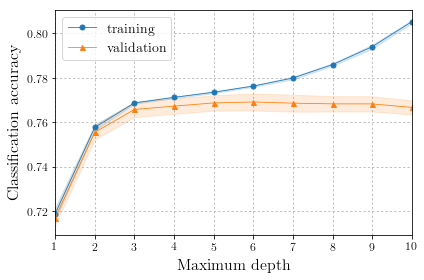

In [11]:
outfile = '/home/jbourbeau/public_html/figures/{}-validation_curve_max_depth.png'.format(pipeline_str)
plot_validation_curve(df_max_depth, xlabel='Maximum depth', outfile=outfile)

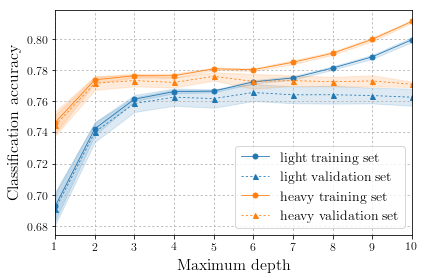

In [12]:
outfile = '/home/jbourbeau/public_html/figures/{}-validation_curve_max_depth_comp.png'.format(pipeline_str)
plot_validation_curve_comp(df_max_depth, xlabel='Maximum depth', outfile=outfile)

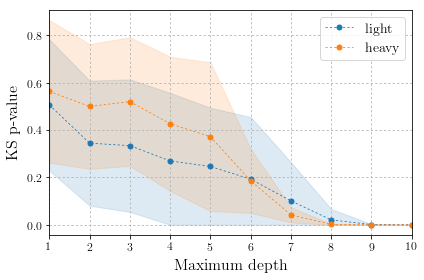

In [13]:
outfile = '/home/jbourbeau/public_html/figures/{}-ks_curve_max_depth_comp.png'.format(pipeline_str)
plot_ks_curve_comp(df_max_depth, xlabel='Maximum depth', outfile=outfile)

## Learning rate

In [14]:
df_learning_rate = pd.read_csv('data/validation-{}-learning_rate-{}-cv{}.csv'.format(pipeline_str, scoring, cv),
                               index_col=0)
df_learning_rate.sort_values('param_value', inplace=True)

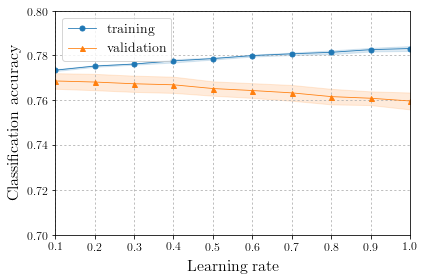

In [15]:
outfile = '/home/jbourbeau/public_html/figures/{}-validation_curve_learning_rate.png'.format(pipeline_str)
plot_validation_curve(df_learning_rate, xlabel='Learning rate', ylim=[0.7, 0.8], outfile=outfile)

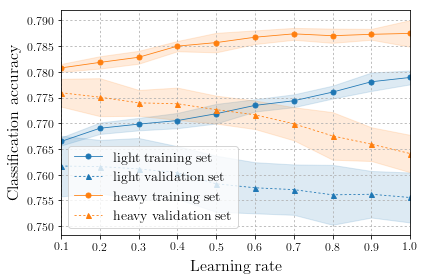

In [16]:
outfile = '/home/jbourbeau/public_html/figures/{}-validation_curve_learning_rate_comp.png'.format(pipeline_str)
plot_validation_curve_comp(df_learning_rate, xlabel='Learning rate', outfile=outfile)

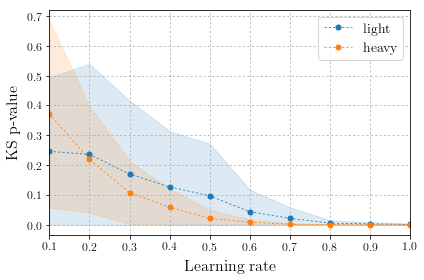

In [17]:
outfile = '/home/jbourbeau/public_html/figures/{}-ks_curve_learning_rate.png'.format(pipeline_str)
plot_ks_curve_comp(df_learning_rate, xlabel='Learning rate', outfile=outfile)

## Number of estimators

In [18]:
df_n_estimators = pd.read_csv('data/validation-{}-n_estimators-{}-cv{}.csv'.format(pipeline_str, scoring, cv),
                              index_col=0)
df_n_estimators.sort_values('param_value', inplace=True)

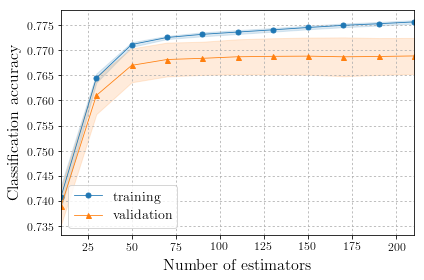

In [19]:
outfile = '/home/jbourbeau/public_html/figures/{}-validation_curve_n_estimators.png'.format(pipeline_str)
plot_validation_curve(df_n_estimators, xlabel='Number of estimators', outfile=outfile)

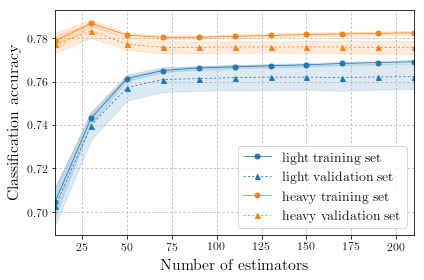

In [20]:
outfile = '/home/jbourbeau/public_html/figures/{}-validation_curve_n_estimators_comp.png'.format(pipeline_str)
plot_validation_curve_comp(df_n_estimators, xlabel='Number of estimators', outfile=outfile)

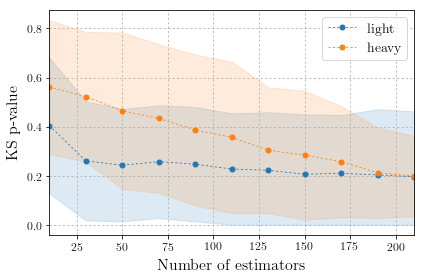

In [21]:
outfile = '/home/jbourbeau/public_html/figures/{}-ks_curve_n_estimators_comp.png'.format(pipeline_str)
plot_ks_curve_comp(df_n_estimators, xlabel='Number of estimators', outfile=outfile)

## Minimum number of samples to split

In [22]:
df_min_samples_split = pd.read_csv('data/validation-{}-min_samples_split-cv10.csv'.format(pipeline_str), index_col=0)
df_min_samples_split.sort_values('param_value', inplace=True)

IOError: File data/validation-GBDT-min_samples_split-cv10.csv does not exist

In [23]:
outfile = '/home/jbourbeau/public_html/figures/{}-validation_curve_min_samples_split.png'.format(pipeline_str)
plot_validation_curve(df_min_samples_split, xlabel='Minimum samples to split', outfile=outfile)

NameError: name 'df_min_samples_split' is not defined

## Minimum number of samples in leaf

In [24]:
df_min_samples_leaf = pd.read_csv('data/validation-{}-min_samples_leaf-{}-cv{}.csv'.format(pipeline_str, scoring, cv), index_col=0)
df_min_samples_leaf.sort_values('param_value', inplace=True)

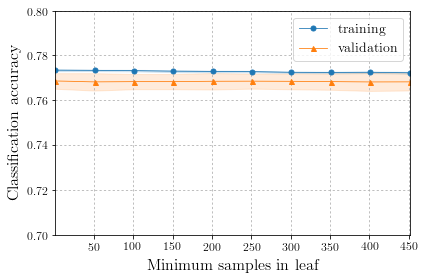

In [25]:
outfile = '/home/jbourbeau/public_html/figures/{}-validation_curve_min_samples_leaf.png'.format(pipeline_str)
plot_validation_curve(df_min_samples_leaf, xlabel='Minimum samples in leaf', ylim=[0.7, 0.8], outfile=outfile)

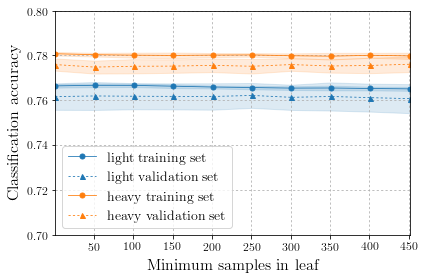

In [26]:
outfile = '/home/jbourbeau/public_html/figures/{}-validation_curve_min_samples_leaf_comp.png'.format(pipeline_str)
plot_validation_curve_comp(df_min_samples_leaf, xlabel='Minimum samples in leaf', ylim=[0.7, 0.8], outfile=outfile)

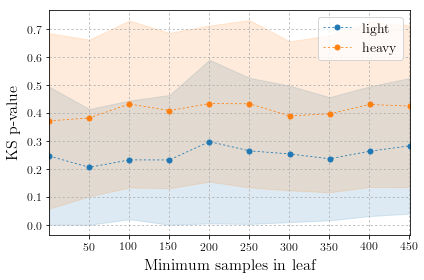

In [27]:
outfile = '/home/jbourbeau/public_html/figures/{}-ks_curve_min_samples_leaf.png'.format(pipeline_str)
plot_ks_curve_comp(df_min_samples_leaf, xlabel='Minimum samples in leaf', outfile=outfile)